### Setup and Configuration

This cell contains all imports and user-configurable parameters for the analysis pipeline.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt # Import for plotting
from IPython.display import display, Markdown
from scipy.stats import linregress 

# --- 1. PANDAS & IPYTHON OPTIONS ---
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)
%load_ext autoreload
%autoreload 2

# --- 2. PROJECT PATH CONFIGURATION ---
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent.parent  # Adjust if your notebook is in a 'notebooks' subdirectory
DATA_DIR = ROOT_DIR / 'data'
SRC_DIR = ROOT_DIR / 'src'

# Add 'src' to the Python path to import custom modules
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# --- 3. IMPORT CUSTOM MODULES ---
import utils
import plotting_utils

# --- 4. ANALYSIS & FILTERING CONFIGURATION ---

# File searching parameters
# FILE_PREFIX = ''  # e.g., '2024'
FILE_CONTAINS_PATTERN = 'df_OHLCV_clean_stocks_etfs'

# # Parameters defining the time windows for metric calculation
PERIOD_PARAMS = {
    'lookback_days': 22,
    'recent_days': 0,
}

# This is not use for filtering, it's use to calculate metrics in SORT_ORDER
# Parameters for filtering the calculated metrics to find candidates
METRIC_FILTERS = {
    'min_lookback_improvement': 0,
    'current_rank_bracket_start': 1,
    'current_rank_bracket_end': 1000,
    # --- Select ONE mode by commenting out the others ---
    # 'Reversal' Mode
    'min_recent_bottom_to_recent_start': 0,
    'min_recent_bottom_to_current': 0,    
    # 'Dip' Mode
    # 'min_current_to_recent_start': 10,
}

# --- 5. VERIFICATION ---
print("--- Path Configuration ---")
print(f"✅ Project Root: {ROOT_DIR}")
print(f"✅ Data Dir:     {DATA_DIR}")
print(f"✅ Source Dir:   {SRC_DIR}")
assert all([ROOT_DIR.exists(), DATA_DIR.exists(), SRC_DIR.exists()]), "A key directory was not found!"

print("\n--- Module Verification ---")
print(f"✅ Successfully imported 'utils' and 'plotting_utils'.")



--- Path Configuration ---
✅ Project Root: c:\Users\ping\Files_win10\python\py311\stocks
✅ Data Dir:     c:\Users\ping\Files_win10\python\py311\stocks\data
✅ Source Dir:   c:\Users\ping\Files_win10\python\py311\stocks\src

--- Module Verification ---
✅ Successfully imported 'utils' and 'plotting_utils'.


In [2]:
print("--- Step 1: Loading latest consolidated Finviz data ---")

# Find the most recent file matching the pattern
# This function is now understood to return List[str] (filenames), not List[Path].
latest_finviz_filepaths = utils.get_recent_files(
    directory_path=DATA_DIR,
    extension='parquet',
    prefix='202',
    contains_pattern='df_finviz_merged_stocks_etfs',
    count=1
)

if not latest_finviz_filepaths:
    raise FileNotFoundError(f"No files found in '{DATA_DIR}' with prefix '{FILE_PREFIX}' and pattern '{FILE_CONTAINS_PATTERN}'")

# Get the filename string from the list
latest_filename = latest_finviz_filepaths[0]

# Manually construct the full path before loading
full_file_path = DATA_DIR / latest_filename
df_finviz_latest = pd.read_parquet(full_file_path, engine='pyarrow')


# --- Robust Index Setting (this logic remains correct) ---
if df_finviz_latest.index.name == 'Ticker':
    print("Info: 'Ticker' is already the index. No action needed.")
elif 'Ticker' in df_finviz_latest.columns:
    print("Info: 'Ticker' column found. Setting it as the DataFrame index.")
    df_finviz_latest.set_index('Ticker', inplace=True)
elif 'ticker' in df_finviz_latest.columns:
    print("Info: 'ticker' column found. Renaming and setting as index.")
    df_finviz_latest.rename(columns={'ticker': 'Ticker'}, inplace=True)
    df_finviz_latest.set_index('Ticker', inplace=True)
elif df_finviz_latest.index.name is None:
    print("Info: Index is unnamed. Assuming it contains tickers and assigning the name 'Ticker'.")
    df_finviz_latest.index.name = 'Ticker'
else:
    print("ERROR: Loaded DataFrame has an unexpected format.")
    print(f"Columns: {df_finviz_latest.columns.tolist()}")
    print(f"Index Name: '{df_finviz_latest.index.name}'")
    raise ValueError("Could not find a 'Ticker' column or a usable index to proceed.")


# Correct the print statement to work with the filename string
print(f"✅ Successfully loaded: {latest_filename}")
print(f"Shape: {df_finviz_latest.shape}")
print(df_finviz_latest.head(3))

--- Step 1: Loading latest consolidated Finviz data ---
Info: Index is unnamed. Assuming it contains tickers and assigning the name 'Ticker'.
✅ Successfully loaded: 2025-09-12_df_finviz_merged_stocks_etfs.parquet
Shape: (1463, 139)
        No.                Company               Index      Sector                   Industry Country Exchange                                   Info  MktCap AUM, M  Rank  Market Cap, M    P/E  Fwd P/E   PEG    P/S    P/B    P/C  P/FCF  Book/sh  Cash/sh  Dividend %  Dividend TTM Dividend Ex Date  Payout Ratio %    EPS  EPS next Q  EPS this Y %  EPS next Y %  EPS past 5Y %  EPS next 5Y %  Sales past 5Y %  Sales Q/Q %  EPS Q/Q %  EPS YoY TTM %  Sales YoY TTM %  Sales, M  Income, M  EPS Surprise %  Revenue Surprise %  Outstanding, M  Float, M  Float %  Insider Own %  Insider Trans %  Inst Own %  Inst Trans %  Short Float %  Short Ratio  Short Interest, M  ROA %   ROE %  ROIC %  Curr R  Quick R  LTDebt/Eq  Debt/Eq  Gross M %  Oper M %  Profit M %  Perf 3D %  Per

In [3]:
# Manually construct the full path before loading
full_file_path = DATA_DIR / 'df_OHLCV_clean_stocks_etfs.parquet'
df_OHLCV = pd.read_parquet(full_file_path, engine='pyarrow')

In [4]:
df_OHLCV

,,Adj Open,Adj High,Adj Low,Adj Close,Volume
Ticker,Date,,,,,
A,2024-09-13,135.7660,136.5590,135.3290,136.2620,924860
AAL,2024-09-13,10.9800,11.1800,10.6100,10.6900,36956000
AAON,2024-09-13,93.6669,94.8421,93.0793,93.7367,208147
AAPL,2024-09-13,222.5440,223.0020,220.8820,221.4690,36937711
ABBV,2024-09-13,187.1660,187.8710,185.1870,187.5040,2815309
...,...,...,...,...,...,...
ZM,2025-09-12,84.6000,85.0000,83.8200,83.9800,1856513
ZS,2025-09-12,287.0000,288.5300,282.4600,283.1900,1340900
ZTO,2025-09-12,19.2600,19.2900,19.0003,19.0600,735599


In [5]:
df_OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 371000 entries, ('A', Timestamp('2024-09-13 00:00:00')) to ('ZWS', Timestamp('2025-09-12 00:00:00'))
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Adj Open   371000 non-null  float64
 1   Adj High   371000 non-null  float64
 2   Adj Low    371000 non-null  float64
 3   Adj Close  371000 non-null  float64
 4   Volume     371000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 15.6+ MB


In [6]:
# Returns a single boolean: True if any NaN exists, False otherwise.
has_nan = df_OHLCV.isna().any().any()

print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


### 2. The Enhanced Analysis Function

This is the core of our new logic. The function `analyze_ticker_channel` will be applied to each ticker. It contains a nested helper function `_perform_regression` to avoid code repetition, which is excellent practice.


In [7]:
def analyze_ticker_trends(df_group, lookback_days=60):
    """
    Analyzes the trends of a ticker's price channel (High/Low) and Volume.
    
    - Price channel analysis uses a unified "worst-case" volatility.
    - Volume analysis uses its own standard pct_change volatility.
    """
    
    def _perform_price_regression(price_series, time_index, unified_std_dev):
        """Helper for High/Low regression, using the shared volatility metric."""
        normalized_price = price_series / price_series.iloc[0]
        try:
            res = linregress(x=time_index, y=normalized_price)
            slope, r_squared = res.slope, res.rvalue**2
        except (ValueError, ZeroDivisionError):
            return {'slope': 0.0, 'r_squared': np.nan, 'penalty_score': np.nan}
        penalty_score = (1 - r_squared) * (unified_std_dev + 1e-9)
        return {'slope': slope, 'r_squared': r_squared, 'penalty_score': penalty_score}

    # --- Main function logic ---
    
    # 1. Select the lookback window
    window = df_group.tail(lookback_days)
    if len(window) < lookback_days or len(window) < 10:
        # Define all expected columns for a clean NaN return
        cols = ['high_slope', 'high_r_squared', 'high_penalty_score',
                'low_slope', 'low_r_squared', 'low_penalty_score',
                'unified_std_dev_returns', 'volume_slope', 'volume_r_squared',
                'volume_std_dev_returns', 'volume_penalty_score']
        return pd.Series(dict.fromkeys(cols, np.nan))

    # 2. Calculate the UNIFIED "Worst-Case" Volatility for PRICE
    yesterday_low = window['Adj Low'].shift(1)
    worst_case_returns = (window['Adj High'] - yesterday_low) / yesterday_low
    unified_std_dev = worst_case_returns.std(ddof=0) # ddof=0 for population std dev
    unified_std_dev = 0.0 if pd.isna(unified_std_dev) else unified_std_dev

    # 3. Analyze Volume Trend and Volatility (SELF-CONTAINED)
    time_index = np.arange(len(window))
    start_volume = window['Volume'].iloc[0]
    
    if start_volume > 0:
        normalized_volume = window['Volume'] / start_volume
        try:
            vol_res = linregress(x=time_index, y=normalized_volume)
            volume_slope, volume_r_squared = vol_res.slope, vol_res.rvalue**2
        except ValueError:
            volume_slope, volume_r_squared = 0.0, np.nan
    else: # Handle zero start volume edge case
        volume_slope, volume_r_squared = 0.0, np.nan
        
    volume_std_dev = window['Volume'].pct_change().std(ddof=0)
    volume_std_dev = 0.0 if pd.isna(volume_std_dev) else volume_std_dev
    volume_penalty_score = (1 - volume_r_squared) * (volume_std_dev + 1e-9)

    # 4. Analyze the High and Low series using the helper
    high_metrics = _perform_price_regression(window['Adj High'], time_index, unified_std_dev)
    low_metrics = _perform_price_regression(window['Adj Low'], time_index, unified_std_dev)
    
    # 5. Combine all results into a single Series
    final_results = {
        'high_slope': high_metrics['slope'], 'high_r_squared': high_metrics['r_squared'], 'high_penalty_score': high_metrics['penalty_score'],
        'low_slope': low_metrics['slope'], 'low_r_squared': low_metrics['r_squared'], 'low_penalty_score': low_metrics['penalty_score'],
        'unified_std_dev_returns': unified_std_dev,
        'volume_slope': volume_slope, 'volume_r_squared': volume_r_squared,
        'volume_std_dev_returns': volume_std_dev, 'volume_penalty_score': volume_penalty_score
    }
    
    return pd.Series(final_results)

### 3. Running the Analysis

Now, we apply our powerful new function to the entire DataFrame using `groupby().apply()`.


In [21]:
# If your ticker level is named, use level='ticker_name'
channel_analysis = df_OHLCV.groupby(level=0).apply(
    analyze_ticker_trends, lookback_days=30
)

print("Channel Analysis Results:")
print(channel_analysis)

Channel Analysis Results:
        high_slope  high_r_squared  high_penalty_score  low_slope  low_r_squared  low_penalty_score  unified_std_dev_returns  volume_slope  volume_r_squared  volume_std_dev_returns  volume_penalty_score
Ticker                                                                                                                                                                                                    
A         0.004657        0.868968            0.002414   0.004453       0.852217           0.002723                 0.018426      0.016230          0.166487                0.363408              0.302905
AAL       0.005664        0.548871            0.013799   0.005516       0.561502           0.013412                 0.030587      0.014044          0.259290                0.291759              0.216109
AAON      0.000417        0.012104            0.073041   0.001150       0.038976           0.071054                 0.073936     -0.026229          0.090557      

In [22]:
channel_analysis.shape

(1484, 11)

In [23]:
# Returns a single boolean: True if any NaN exists, False otherwise.
has_nan = channel_analysis.isna().any().any()

print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


In [24]:
channel_analysis.loc['MSFT']

high_slope                -0.002190
high_r_squared             0.800814
high_penalty_score         0.001483
low_slope                 -0.002053
low_r_squared              0.812068
low_penalty_score          0.001399
unified_std_dev_returns    0.007443
volume_slope              -0.002470
volume_r_squared           0.018925
volume_std_dev_returns     0.306689
volume_penalty_score       0.300885
Name: MSFT, dtype: float64

### Isolate a Single Ticker and Select Lookback Window

To simulate the `groupby().apply()` process, we'll manually grab the data for one ticker (`MSFT`) and then select our 60-day lookback window.

In [25]:
# Manually select the data for 'MSFT'
single_ticker_df = df_OHLCV.loc['MSFT']

# Define lookback and create the window
lookback_days = 30
window = single_ticker_df.tail(lookback_days)

print(f"Selected the last {lookback_days} days for 'MSFT'.")
print(f"Window shape: {window.shape}")
print(f'window.tail(3):\n{window.tail(3)}')
# print(f'window:\n{window}')

Selected the last 30 days for 'MSFT'.
Window shape: (30, 5)
window.tail(3):
            Adj Open  Adj High  Adj Low  Adj Close    Volume
Date                                                        
2025-09-10    502.98    503.23  496.720     500.37  21611800
2025-09-11    502.25    503.17  497.880     501.01  18881600
2025-09-12    506.51    512.55  503.868     509.90  23242411


### Part A: Price Channel Analysis Verification

### Step 1: Calculate the Unified "Worst-Case" Volatility

This is our special metric. Let's calculate it and see what it looks like.

In [26]:
# Get yesterday's low by shifting the 'Adj Low' column
yesterday_low = window['Adj Low'].shift(1)

# Calculate the worst-case returns
worst_case_returns = (window['Adj High'] - yesterday_low) / yesterday_low

# Calculate the final standard deviation for this series
unified_std_dev = worst_case_returns.std(ddof=0) # ddof=0 for population std dev

print("First 5 values of 'yesterday_low':")
print(yesterday_low.head())
print("\nFirst 5 values of 'worst_case_returns':")
print(worst_case_returns.head())
print(f"\nFINAL UNIFIED STD DEV (for Price): {unified_std_dev:.6f}")

First 5 values of 'yesterday_low':
Date
2025-08-01        NaN
2025-08-04    520.005
2025-08-05    527.263
2025-08-06    526.375
2025-08-07    523.170
Name: Adj Low, dtype: float64

First 5 values of 'worst_case_returns':
Date
2025-08-01         NaN
2025-08-04    0.033388
2025-08-05    0.017363
2025-08-06    0.008458
2025-08-07    0.007747
dtype: float64

FINAL UNIFIED STD DEV (for Price): 0.007443


### Step 2: Analyze the `Adj High` Trend

Now we perform the full analysis on the `Adj High` series, using the `unified_std_dev` we just calculated for its penalty score.

High Slope: -0.002190
High R-Squared: 0.8008
High Penalty Score: 0.001483


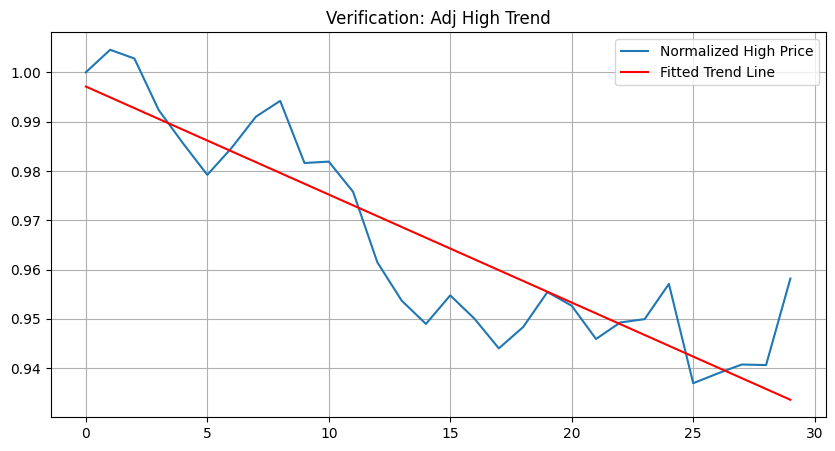

In [27]:
# Normalize the Adj High series
normalized_high = window['Adj High'] / window['Adj High'].iloc[0]

# Create the time index for regression
time_index = np.arange(len(window))

# Perform regression
high_res = linregress(x=time_index, y=normalized_high)
high_slope = high_res.slope
high_r_squared = high_res.rvalue**2

# Calculate penalty using our UNIFIED metric
high_penalty_score = (1 - high_r_squared) * (unified_std_dev + 1e-9)

print(f"High Slope: {high_slope:.6f}")
print(f"High R-Squared: {high_r_squared:.4f}")
print(f"High Penalty Score: {high_penalty_score:.6f}")

# --- Visualize to confirm ---
plt.figure(figsize=(10, 5))
plt.plot(time_index, normalized_high, label='Normalized High Price')
plt.plot(time_index, high_res.intercept + high_res.slope * time_index, 'r', label='Fitted Trend Line')
plt.title('Verification: Adj High Trend')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Analyze the `Adj Low` Trend

We repeat the exact same process for the `Adj Low` series.

Low Slope: -0.002053
Low R-Squared: 0.8121
Low Penalty Score: 0.001399


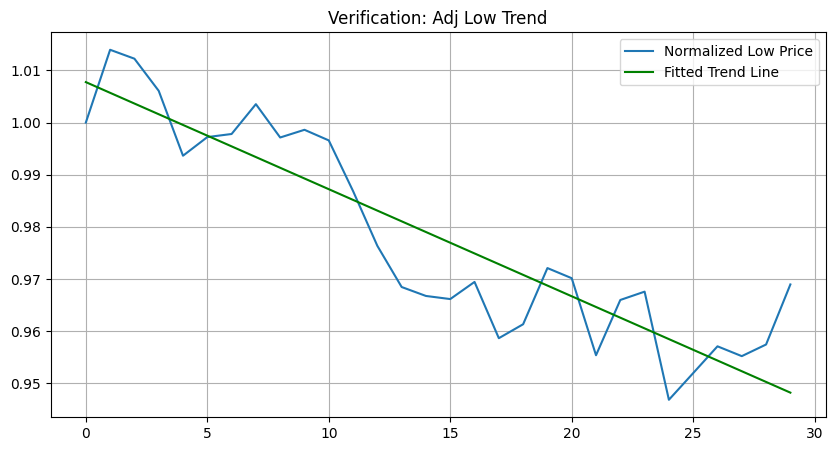

In [28]:
# Normalize the Adj Low series
normalized_low = window['Adj Low'] / window['Adj Low'].iloc[0]

# Perform regression (time_index is the same)
low_res = linregress(x=time_index, y=normalized_low)
low_slope = low_res.slope
low_r_squared = low_res.rvalue**2

# Calculate penalty using the SAME UNIFIED metric
low_penalty_score = (1 - low_r_squared) * (unified_std_dev + 1e-9)

print(f"Low Slope: {low_slope:.6f}")
print(f"Low R-Squared: {low_r_squared:.4f}")
print(f"Low Penalty Score: {low_penalty_score:.6f}")

# --- Visualize to confirm ---
plt.figure(figsize=(10, 5))
plt.plot(time_index, normalized_low, label='Normalized Low Price')
plt.plot(time_index, low_res.intercept + low_res.slope * time_index, 'g', label='Fitted Trend Line')
plt.title('Verification: Adj Low Trend')
plt.legend()
plt.grid(True)
plt.show()

### Part B: Volume Analysis Verification

### Step 4: Analyze the `Volume` Trend (Slope & R-Squared)

This is a self-contained analysis. First, we'll find the trend line for the volume.

Volume Slope: -0.002470
Volume R-Squared: 0.0189


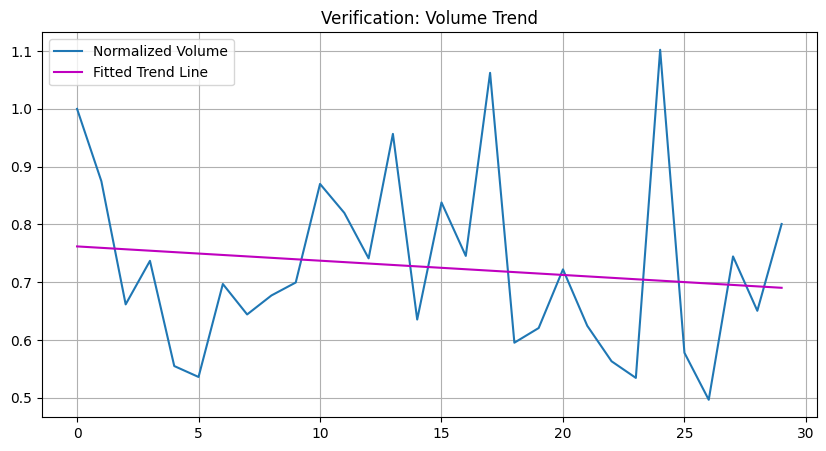

In [29]:
# Normalize the Volume series
start_volume = window['Volume'].iloc[0]
normalized_volume = window['Volume'] / start_volume

# Perform regression
vol_res = linregress(x=time_index, y=normalized_volume)
volume_slope = vol_res.slope
volume_r_squared = vol_res.rvalue**2

print(f"Volume Slope: {volume_slope:.6f}")
print(f"Volume R-Squared: {volume_r_squared:.4f}")

# --- Visualize to confirm ---
plt.figure(figsize=(10, 5))
plt.plot(time_index, normalized_volume, label='Normalized Volume')
plt.plot(time_index, vol_res.intercept + vol_res.slope * time_index, 'm', label='Fitted Trend Line')
plt.title('Verification: Volume Trend')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Calculate `Volume` Volatility and Penalty Score

Here, we use the standard `pct_change()` method for volatility, as planned.

In [30]:
# Calculate standard pct_change returns for volume
volume_returns = window['Volume'].pct_change()

# Calculate the standard deviation for volume
volume_std_dev = volume_returns.std(ddof=0)

# Calculate the final penalty score for volume
volume_penalty_score = (1 - volume_r_squared) * (volume_std_dev + 1e-9)

print("First 5 values of standard volume returns:")
print(volume_returns.head())
print(f"\nFINAL STD DEV (for Volume): {volume_std_dev:.6f}")
print(f"Volume Penalty Score: {volume_penalty_score:.6f}")

First 5 values of standard volume returns:
Date
2025-08-01         NaN
2025-08-04   -0.125221
2025-08-05   -0.243694
2025-08-06    0.113924
2025-08-07   -0.247082
Name: Volume, dtype: float64

FINAL STD DEV (for Volume): 0.306689
Volume Penalty Score: 0.300885


### Final Step: Consolidate All Verified Metrics

This final cell gathers all the numbers we've just calculated into a single pandas Series, mimicking the final output of our function for this one ticker. You can compare this output directly to the 'MSFT' row from the full `groupby().apply()` run.

In [31]:
# Gather all the individual pieces we have calculated and verified
final_verified_metrics = pd.Series({
    'high_slope': high_slope, 'high_r_squared': high_r_squared, 'high_penalty_score': high_penalty_score,
    'low_slope': low_slope, 'low_r_squared': low_r_squared, 'low_penalty_score': low_penalty_score,
    'unified_std_dev_returns': unified_std_dev,
    'volume_slope': volume_slope, 'volume_r_squared': volume_r_squared,
    'volume_std_dev_returns': volume_std_dev, 'volume_penalty_score': volume_penalty_score
})

print("--- Final Verified Metrics for MSFT ---")
print(final_verified_metrics)

--- Final Verified Metrics for MSFT ---
high_slope                -0.002190
high_r_squared             0.800814
high_penalty_score         0.001483
low_slope                 -0.002053
low_r_squared              0.812068
low_penalty_score          0.001399
unified_std_dev_returns    0.007443
volume_slope              -0.002470
volume_r_squared           0.018925
volume_std_dev_returns     0.306689
volume_penalty_score       0.300885
dtype: float64


# Normalize the Residual:  
To solve the "volatility is not constant" problem, we should not use the raw dollar residual. We should normalize it by dividing it by the standard deviation of the residuals over the lookback period. This creates a "Standardized Residual" or "Z-Score".

### Setup: Imports and a Special Sample Price Series

First, let's create a price series that has a clear uptrend but with two distinct volatility "regimes": a quiet first half and a choppy, more volatile second half. This will help us see the problem with raw residuals.

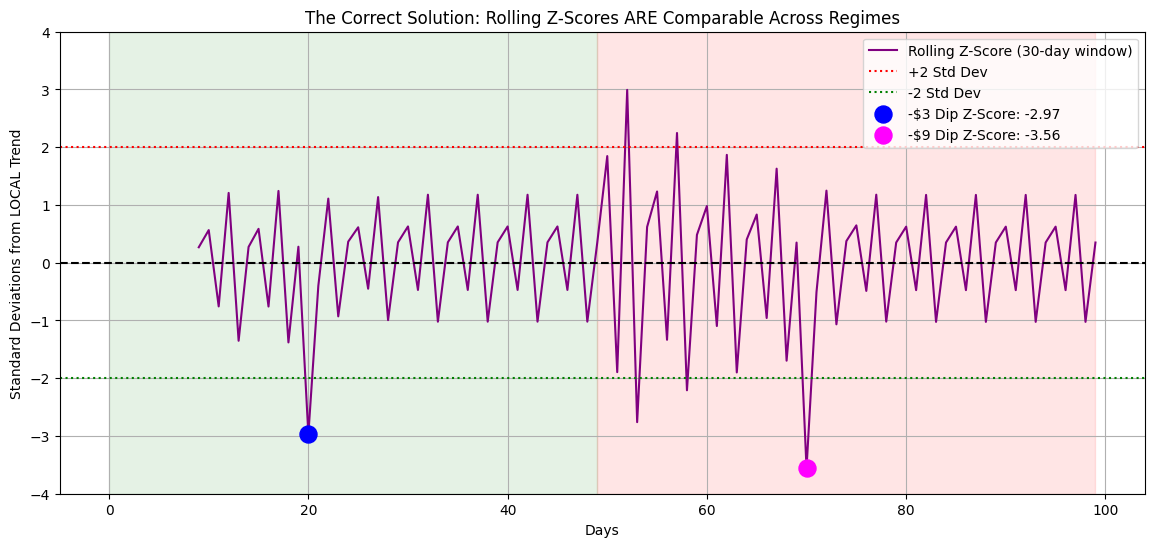

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# --- A PERFECT, MANUALLY-CRAFTED EXAMPLE (Corrected) ---
time_index = np.arange(100)
trend = 0.5 * time_index + 100

# Manually create the residuals
quiet_residuals = pd.Series([0.5, -0.5, 1.0, -1.0, 0.25] * 10) # 50 elements
volatile_residuals = pd.Series([1.5, -1.5, 3.0, -3.0, 0.75] * 10) # 50 elements

# The Key Intervention
quiet_residuals.iloc[20] = -3.0  # -$3 dip in the quiet period
volatile_residuals.iloc[20] = -9.0 # -$9 dip in the volatile period

# Combine to create the price series
all_residuals = pd.Series(np.concatenate([quiet_residuals, volatile_residuals]))
price = trend + all_residuals
price_series = pd.Series(price, name='Adj_High')


# --- THE CORRECT IMPLEMENTATION: ROLLING Z-SCORE ---

# First, get the trend and raw residuals as before
res = linregress(x=time_index, y=price_series)
predicted_price = res.intercept + res.slope * time_index
raw_residuals = price_series - predicted_price

# Now, calculate the ROLLING mean and std dev over a 30-day window
rolling_mean = raw_residuals.rolling(window=30, min_periods=10).mean()
rolling_std = raw_residuals.rolling(window=30, min_periods=10).std()

# Calculate the ROLLING Z-SCORE
# Z-Score = (Current Residual - Rolling Mean of Residuals) / Rolling Std Dev of Residuals
rolling_z_score = (raw_residuals - rolling_mean) / rolling_std

# --- Plot the final, correct result ---
plt.figure(figsize=(14, 6))
plt.plot(time_index, rolling_z_score, label='Rolling Z-Score (30-day window)', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2.0, color='red', linestyle=':', label='+2 Std Dev')
plt.axhline(-2.0, color='green', linestyle=':', label='-2 Std Dev')
plt.axvspan(0, 49, color='green', alpha=0.1)
plt.axvspan(49, 99, color='red', alpha=0.1)

# Highlight our specific events to confirm
plt.scatter(20, rolling_z_score.iloc[20], color='blue', s=150, zorder=5, label=f"-$3 Dip Z-Score: {rolling_z_score.iloc[20]:.2f}")
plt.scatter(70, rolling_z_score.iloc[70], color='magenta', s=150, zorder=5, label=f"-$9 Dip Z-Score: {rolling_z_score.iloc[70]:.2f}")

plt.title('The Correct Solution: Rolling Z-Scores ARE Comparable Across Regimes')
plt.ylabel('Standard Deviations from LOCAL Trend')
plt.xlabel('Days')
plt.legend()
plt.grid(True)
plt.ylim(-4, 4) # Set a consistent y-axis
plt.show()

**Aha! Moment:** Look at the Z-Score plot. The peaks and troughs now have a consistent scale. A deviation that was statistically significant in the quiet period (e.g., around day 20, where it hits -2.0) is just as prominent as a significant deviation in the volatile period (e.g., around day 60). We now have a reliable oscillator.

### The Final Visualization: Tying It All Together

This final plot shows how to use this concept in practice. We plot the price with "bands" representing +/- 2 standard deviations and the Z-Score oscillator directly below it.

This visual demonstration should make the concept crystal clear. The Z-Score transforms the noisy, hard-to-interpret raw deviations into a clean, consistent, and actionable oscillator that we can now confidently add to our feature factory.